In [1]:

import copy
import pprint
import json
import os, psutil
from collections import defaultdict

import gc
import time
import numpy as np
import matplotlib.pyplot as plt

from tqdm import tqdm
from dataclasses import dataclass

In [2]:

import torch 
from transformers import (
    AutoModelForCausalLM,
    AutoTokenizer,
    PreTrainedModel,
    PreTrainedTokenizer,
)
from vllm import LLM, SamplingParams


In [2]:
from sal.models.reward_models import RLHFFlow

from sal.search.utils import Beam, build_conv, generate_k_steps, last
from sal.config import Config
from sal.models.reward_models import PRM
from sal.utils.score import aggregate_scores

In [4]:
cpu_percent = psutil.cpu_percent(interval=1)
print(f"CPU Usage: {cpu_percent}%")

# RAM usage
virtual_memory = psutil.virtual_memory()
print(f"Total RAM: {virtual_memory.total / (1024 ** 3):.2f} GB")
print(f"Available RAM: {virtual_memory.available / (1024 ** 3):.2f} GB")
print(f"Used RAM: {virtual_memory.used / (1024 ** 3):.2f} GB")
print(f"RAM Usage Percentage: {virtual_memory.percent}%")

if torch.cuda.is_available():
    GPUS = os.environ.get('CUDA_VISIBLE_DEVICES', "0").split(',')
    print(GPUS)
    for gpu_index in  GPUS:
        gpu_index = int(gpu_index)
        gpu_name = torch.cuda.get_device_name(gpu_index)
        print(f"\n-> gpu {gpu_index}: {gpu_name}")
        # gpu_index = 0  # Change this if you have multiple GPUs
        total_memory = torch.cuda.get_device_properties(gpu_index).total_memory
        reserved_memory = torch.cuda.memory_reserved(gpu_index)
        allocated_memory = torch.cuda.memory_allocated(gpu_index)
        free_memory = reserved_memory - allocated_memory
    
        print(f"Total GPU Memory: {total_memory / 1024 ** 3:.2f} GB")
        print(f"Allocated GPU Memory: {allocated_memory / 1024 ** 3:.2f} GB")
        print(f"Available GPU Memory: {free_memory / 1024 ** 3:.2f} GB")
else:
    print("CUDA is not available.")

CPU Usage: 0.1%
Total RAM: 503.68 GB
Available RAM: 469.96 GB
Used RAM: 15.77 GB
RAM Usage Percentage: 6.7%
['0', '1', '2', '3']

-> gpu 0: Tesla V100S-PCIE-32GB
Total GPU Memory: 31.73 GB
Allocated GPU Memory: 0.00 GB
Available GPU Memory: 0.00 GB

-> gpu 1: Tesla V100S-PCIE-32GB
Total GPU Memory: 31.73 GB
Allocated GPU Memory: 0.00 GB
Available GPU Memory: 0.00 GB

-> gpu 2: Tesla V100S-PCIE-32GB
Total GPU Memory: 31.73 GB
Allocated GPU Memory: 0.00 GB
Available GPU Memory: 0.00 GB

-> gpu 3: Tesla V100S-PCIE-32GB
Total GPU Memory: 31.73 GB
Allocated GPU Memory: 0.00 GB
Available GPU Memory: 0.00 GB


In [5]:
# base_path
base_path = '/groups/kjun/tnn/datasets/'

# dataset path
dataset_path = base_path + "/prm800k/math_splits"

# llm and prm path
llm_path = base_path + "/Llama-3.2-1B-Instruct-GGUF/Llama-3.2-1B-Instruct.Q4_K_M.gguf"
prm_path = base_path + "/Llama3.1-8B-PRM-Deepseek-Data-GGUF/Llama3.1-8B-PRM-Deepseek-Data.Q4_K_M.gguf"

llm_tokenizer_path = base_path + "/Llama-3.2-1B-Instruct"
prm_tokenizer_path = base_path + "/Llama3.1-8B-PRM-Deepseek-Data"

In [58]:
# class RLHFFlow(PRM):
#     def load_model_and_tokenizer(
#         self, **model_kwargs
#     ) -> tuple[PreTrainedModel, PreTrainedTokenizer]:
#         prm_tokenizer_path = base_path + "/Llama3.1-8B-PRM-Deepseek-Data"
#         print(prm_tokenizer_path)
#         tokenizer = AutoTokenizer.from_pretrained(
#             prm_tokenizer_path,
#         )
#         model = AutoModelForCausalLM.from_pretrained(
#             prm_tokenizer_path,
#             device_map="auto",
#             max_memory={1: "16GB", 2: "16GB", 3: "16GB"},
#             torch_dtype=torch.bfloat16,
#             **model_kwargs,
#         ).eval()
#         tokenizer.padding_side = "right"
#         tokenizer.pad_token = tokenizer.eos_token
#         model.config.pad_token_id = model.config.eos_token_id

#         plus_tag_id = tokenizer.encode("+")[-1]
#         minus_tag_id = tokenizer.encode("-")[-1]
#         self.candidate_tokens = [plus_tag_id, minus_tag_id]

#         return model, tokenizer

#     def score(
#         self,
#         questions: list[str],
#         outputs: list[list[str]],
#         batched: bool = True,
#         batch_size=8,
#     ) -> list[list[float]]:
#         if batched is True:
#             print(f"batched")
#             return self._score_batched(questions, outputs, batch_size=batch_size)
#         else:
#             print(f"single")
#             return self._score_single(questions, outputs)

#     def _score_single(self, questions: list[str], outputs: list[list[str]]):
#         # reference code: https://github.com/RLHFlow/RLHF-Reward-Modeling/blob/main/math-rm/prm_evaluate.py
#         all_scores = []
#         for question, answers in zip(questions, outputs, strict=True):
#             all_step_scores = []
#             for ans in answers:
#                 single_step_score = []
#                 conversation = []
#                 ans_list = ans.split("\n\n")
#                 # print(ans_list)
#                 for k in range(len(ans_list)):
#                     if k == 0:
#                         # TODO: add the system prompt like we did for math shepard?
#                         text = question + " " + ans_list[0]
#                     else:
#                         text = ans_list[k]
#                     conversation.append({"content": text, "role": "user"})
#                     conversation.append({"content": "+", "role": "assistant"})
#                     # print(conversation)
#                     input_ids = self.tokenizer.apply_chat_template(
#                         conversation, return_tensors="pt"
#                     ).to(self.model.device)
#                     # print(input_ids)
#                     with torch.no_grad():
#                         # model_outputs = self.model(input_ids)
#                         # print(f"model_outputs")
#                         # print(model_outputs)
#                         # print(f"model_outputs.logits")
#                         # print(model_outputs.logits)
#                         # logits = model_outputs.logits[:,-3,self.candidate_tokens]
#                         logits = self.model(input_ids).logits[
#                             :, -3, self.candidate_tokens
#                         ]  # simple version, the +/- is predicted by the '-3' position
#                         # print(logits)
#                         step_scores = logits.softmax(dim=-1)[
#                             :, 0
#                         ]  # 0 means the prob of + (1 mean -)
#                         # print(step_scores)
#                         single_step_score.append(
#                             step_scores[0]
#                             .detach()
#                             .to("cpu", dtype=torch.float32)
#                             .item()
#                         )
#                 # stop
#                 all_step_scores.append(single_step_score)
#             all_scores.append(all_step_scores)
#         return all_scores



In [74]:
# class RLHFFlow(PRM):
#     def load_model_and_tokenizer(
#         self, **model_kwargs
#     ) -> tuple[PreTrainedModel, PreTrainedTokenizer]:
#         tokenizer = AutoTokenizer.from_pretrained(
#             "RLHFlow/Llama3.1-8B-PRM-Deepseek-Data"
#         )
#         model = AutoModelForCausalLM.from_pretrained(
#             "RLHFlow/Llama3.1-8B-PRM-Deepseek-Data",
#             device_map="auto",
#             max_memory={1: "16GB", 2: "16GB", 3: "16GB"},
#             torch_dtype=torch.bfloat16,
#             **model_kwargs,
#         ).eval()
#         tokenizer.padding_side = "right"
#         tokenizer.pad_token = tokenizer.eos_token
#         model.config.pad_token_id = model.config.eos_token_id

#         plus_tag_id = tokenizer.encode("+")[-1]
#         minus_tag_id = tokenizer.encode("-")[-1]
#         self.candidate_tokens = [plus_tag_id, minus_tag_id]

#         return model, tokenizer

#     def score(
#         self,
#         questions: list[str],
#         outputs: list[list[str]],
#         batched: bool = True,
#         batch_size=8,
#     ) -> list[list[float]]:
#         if batched is True:
#             return self._score_batched(questions, outputs, batch_size=batch_size)
#         else:
#             return self._score_single(questions, outputs)

#     def _score_single(self, questions: list[str], outputs: list[list[str]]):
#         # reference code: https://github.com/RLHFlow/RLHF-Reward-Modeling/blob/main/math-rm/prm_evaluate.py
#         all_scores = []
#         for question, answers in zip(questions, outputs, strict=True):
#             all_step_scores = []
#             for ans in answers:
#                 single_step_score = []
#                 conversation = []
#                 ans_list = ans.split("\n\n")
#                 for k in range(len(ans_list)):
#                     if k == 0:
#                         # TODO: add the system prompt like we did for math shepard?
#                         text = question + " " + ans_list[0]
#                     else:
#                         text = ans_list[k]
#                     conversation.append({"content": text, "role": "user"})
#                     conversation.append({"content": "+", "role": "assistant"})
#                     input_ids = self.tokenizer.apply_chat_template(
#                         conversation, return_tensors="pt"
#                     ).to(self.model.device)
#                     with torch.no_grad():
#                         logits = self.model(input_ids).logits[
#                             :, -3, self.candidate_tokens
#                         ]  # simple version, the +/- is predicted by the '-3' position
#                         step_scores = logits.softmax(dim=-1)[
#                             :, 0
#                         ]  # 0 means the prob of + (1 mean -)
#                         # print(scores)
#                         single_step_score.append(
#                             step_scores[0]
#                             .detach()
#                             .to("cpu", dtype=torch.float32)
#                             .item()
#                         )

#                 all_step_scores.append(single_step_score)
#             all_scores.append(all_step_scores)
#         return all_scores

#     def _score_batched(
#         self, questions: list[str], outputs: list[list[str]], batch_size: int = 2
#     ):
#         # The RLHFlow models are trained to predict the "+" or "-" tokens in a dialogue, but since these are not unique
#         # we need to introduce a dummy special token here for masking.

#         special_tok_id = self.tokenizer("ки", return_tensors="pt").input_ids[0, 1]
#         # We construct two parallel dialogues, one with a "+" token per assistant turn, the other with the dummy token "ки" for masking
#         conversations = []
#         conversations2 = []
#         for question, answers in zip(questions, outputs, strict=True):
#             for ans in answers:
#                 conversation = []
#                 conversation2 = []
#                 ans_list = ans.split("\n\n")
#                 for k in range(len(ans_list)):
#                     if k == 0:
#                         text = question + " " + ans_list[0]
#                     else:
#                         text = ans_list[k]
#                     conversation.append({"content": text, "role": "user"})
#                     conversation.append({"content": "+", "role": "assistant"})

#                     # we track to location of the special token with ки in order to extract the scores
#                     conversation2.append({"content": text, "role": "user"})
#                     conversation2.append({"content": "ки", "role": "assistant"})

#                 conversations.append(conversation)
#                 conversations2.append(conversation2)

#         output_scores = []
#         for i in range(0, len(conversations), batch_size):
#             convs_batch = conversations[i : i + batch_size]
#             convs2_batch = conversations2[i : i + batch_size]
#             inputs_batch = self.tokenizer.apply_chat_template(
#                 convs_batch, padding=True, return_tensors="pt"
#             ).to(self.model.device)
#             inputs2_batch = self.tokenizer.apply_chat_template(
#                 convs2_batch, padding=True, return_tensors="pt"
#             ).to(self.model.device)
#             assert inputs_batch.shape == inputs2_batch.shape
#             with torch.no_grad():
#                 logits = self.model(inputs_batch).logits[:, :, self.candidate_tokens]
#                 scores = logits.softmax(dim=-1)[
#                     :, :, 0
#                 ]  # 0 means the prob of + (1 mean -)

#                 for i in range(len(convs_batch)):
#                     # We slice on the N-1 token since the model is trained to predict the Nth one ("+" in this case)
#                     step_scores_flat = scores[i, :-1][
#                         inputs2_batch[i, 1:] == special_tok_id
#                     ].tolist()
#                     output_scores.append(step_scores_flat)

#         # reshape the output scores to match the input
#         reshaped_output_scores = []
#         counter = 0

#         for question, answers in zip(questions, outputs):
#             scores = []
#             for answer in answers:
#                 scores.append(output_scores[counter])
#                 counter += 1
#             reshaped_output_scores.append(scores)

#         return reshaped_output_scores

In [6]:
# del(prm)
prm = RLHFFlow(prm_tokenizer_path)

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

In [7]:
print(prm.model.device)

cuda:0


In [8]:
# del(prm)
gc.collect();torch.cuda.empty_cache();
print('#--- memory:', torch.cuda.memory_allocated(0)/(1024**3))

#--- memory: 3.0098419189453125


In [34]:
# prompt = 'Below is the graph of $y = a \\sin (bx + c) + d$ for some positive constants $a,$ $b,$ $c,$ and $d.$  Find the smallest possible value of $c.$\n\n[asy]import TrigMacros;\n\nsize(400);\n\nreal f(real x)\n{\n\treturn 2*sin(3*x + pi) + 1;\n}\n\ndraw(graph(f,-3*pi,3*pi,n=700,join=operator ..),red);\ntrig_axes(-3*pi,3*pi,-4,4,pi/2,1);\nlayer();\nrm_trig_labels(-5,5, 2);\n\nlabel("$1$", (0,1), E);\nlabel("$2$", (0,2), E);\nlabel("$3$", (0,3), E);\nlabel("$-1$", (0,-1), E);\nlabel("$-2$", (0,-2), E);\nlabel("$-3$", (0,-3), E);\n[/asy]' 
prompt =  'If $f(x) = \frac{3x-2}{x-2}$, what is the value of $f(-2) +f(-1)+f(0)$? Express your answer as a common fraction.'
max_new_tokens = 1024 
num_runs = 5

In [1]:
# gpu_memory_utilization=0.2
llm = LLM(
    model = llm_tokenizer_path,
    gpu_memory_utilization = 0.2,  # Utilize 50% of GPU memory
    max_model_len = 5000,
    dtype = "float16",
    seed = 123)

gc.collect();torch.cuda.empty_cache();
print('#--- memory:', torch.cuda.memory_allocated(0)/(1024**3))

NameError: name 'LLM' is not defined

In [10]:
data_by_levels = defaultdict(list)
with open(f"{dataset_path}/test.jsonl", 'r', encoding='utf-8') as filein:
    for line in filein:
        if line.strip():
            data = json.loads(line)
            # print(data['level'])
            data_by_levels[f"{data['level']}"].append(data)

    # data =  [json.loads(line) for line in filein if line.strip()]
    # pprint.pprint(data, compact=True)

for key in range(1,6):
    key = str(key)
    print(f"{key}: {len(data_by_levels[key])}")
    # pprint.pprint(data_by_levels[key][:2], compact=True)
# print(data_by_levels.keys())
# pprint.pprint(data_by_levels['2'], compact=True)

1: 43
2: 90
3: 105
4: 128
5: 134


In [11]:
def _maxk_sequence(batch_of_prompts, config: Config):
    '''
    '''

    convs = [
        [
            {"role": "system", "content": config.system_prompt},
            {"role": "user", "content": prompt},
        ]
        for prompt in batch_of_prompts
    ]

    tokenizer = llm.get_tokenizer()
    if config.custom_chat_template is not None:
        tokenizer.chat_template = config.custom_chat_template

    templated_convs = tokenizer.apply_chat_template(
        convs,
        tokenize=False,
        add_generation_prompt=True
    )

    # duplicate convs to generate config.n completions per prompt
    # so we can do continous batching
    # this makes [p1, p2, p3, p4] become [p1, p1, p2, p2, p3, p3, p4, p4] for e.g. config.n=2
    # templated_convs = [c for conv in templated_convs for c in [conv] * config.n]


    sampling_params = SamplingParams(
        temperature=config.temperature,
        max_tokens=config.max_tokens,
        top_p=config.top_p,
        n=1,  # Since we've already duplicated the prompt_token_ids, we only need to generate 1 completion per prompt
    )

    # initialize empty lists for completions and completion tokens
    completions = [[] for _ in range(len(batch_of_prompts))]
    completion_tokens = [[] for _ in range(len(batch_of_prompts))]

    num_gens = config.n
    for i in range(len(completions)):
        for _ in range(config.n // num_gens):
            responses = llm.generate(
                [c for conv in templated_convs for c in [conv] * num_gens],
                sampling_params=sampling_params,
                use_tqdm=False,
            )
            print(len(responses))

            for r in responses[:num_gens]:
                for output in r.outputs:
                    completions[i].append(output.text)
                    completion_tokens[i].append(len(output.token_ids))


    print(f"completion token counts: {completion_tokens}")

    # Check we generated the correct number of completions for each prompt
    for c in completions:
        if len(c) != config.n:
            raise ValueError(f"Generated {len(c)} completions instead of {config.n}")

    scores = prm.score(batch_of_prompts, completions)
    print(scores)
    agg_scores = [
        [aggregate_scores(s, config.agg_strategy) for s in score] for score in scores
    ]
    # print(scores)
    print(agg_scores)
    # print(len(agg_scores[0]))

    max_score = 0
    max_score_arr = np.zeros(config.n)
    for i, score in enumerate(agg_scores[0]):
        if score > max_score:
            max_score = score
        max_score_arr[i] = max_score

    # del(completions)
    # del(responses)
    # print(max_score_arr)
    # stop
    return max_score_arr

In [12]:
def exp_maxk_score(num_trials, batch_of_prompts, config: Config):

    trial_max_score_arr = np.zeros((num_trials, config.n))
    # for i in tqdm(range(num_trials)):
    for p_idx, prompt in enumerate(batch_of_prompts):
        print(f"{p_idx}: {prompt}")
        for i in range(num_trials):
            # print(f"i_trial = {i}")
            trial_max_score_arr[i] = _maxk_sequence([prompt], config)

        xrange = np.arange(1,config.n+1)
        score_mean = np.mean(trial_max_score_arr, axis=0)
        score_std = np.std(trial_max_score_arr, axis=0, ddof=1)
        score_std /= np.sqrt(num_trials)
        plt.plot(xrange, score_mean)
        plt.fill_between(xrange, score_mean-score_std, score_mean+score_std, alpha=0.3)
        # for i in range(num_trials):
        #     plt.plot(xrange, trial_max_score_arr[i], alpha=0.3, color='b')
    plt.xticks(xrange)
    plt.show()

    return trial_max_score_arr

In [13]:
config = Config()
config.n = 5
num_trials = 4

0: The set of points $(x,y,z)$ that satisfy
\[2x = 3y = -z\]is a line.

The set of points $(x,y,z)$ that satisfy
\[6x = -y = -4z\]is another line.

Find the angle between these lines, in degrees.
5
completion token counts: [[570, 510, 669, 619, 499]]
[[[0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5], [0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5], [0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5], [0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5], [0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5]]]
[[0.5, 0.5, 0.5, 0.5, 0.5]]
5
completion token counts: [[751, 590, 656, 705, 788]]
[[[0.5, 0.5], [0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5], [0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5], [0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5], [0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5]]]
[[0.5, 0.5, 0.5, 0.5, 0.5]]
5
completion token counts: [[780, 648, 714, 495, 923

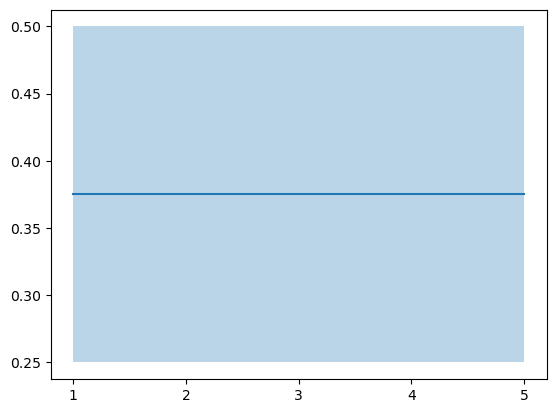

time taken: 69.53726148605347


In [14]:
# level-4 questions
batch_of_prompts = [data_by_levels['4'][0]['problem']]
# print(batch_of_prompts)
start_time = time.time()
exp_maxk_score(num_trials, batch_of_prompts, config)
print(f"time taken: {time.time()-start_time}")